$$\textbf{PLN. Tarea 3: Minería de texto básica}$$
$$\textit{Y. Sarahi García Gozález}$$

<font size=4.5 color='lightblue'>

$\textit{Librerías}$

In [243]:
from nltk.tokenize import TweetTokenizer
import nltk
import numpy as np
import pandas as pd
from math import log10
from sklearn import preprocessing
from tsne import tsne
from itertools import combinations
from sklearn.feature_selection import SelectKBest,chi2
import matplotlib.pyplot as plt
import sklearn
from sklearn import svm
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_recall_fscore_support,roc_auc_score

In [12]:
print("Tarea realizada en MacOs. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)
print("NLTK version:", nltk.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)

Tarea realizada en MacOs. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.11.5
NumPy version: 1.23.5
NLTK version: 3.8.1
Pandas version: 2.1.4
Scikit-learn version: 1.3.0


$\textit{Preparación de texto, corpus y diccionarios}$

In [13]:
def get_text_from_file(path_corpus,path_truth):

    tr_txt=[]
    tr_labels=[]

    with open(path_corpus, "r") as f_corpus,open(path_truth, "r") as f_truth:
        for tweet in f_corpus:
            tr_txt += [tweet]
        for label in f_truth:
            tr_labels += [label]   
             
    return tr_txt, tr_labels


def create_corpus_from_text(text,tokenizer):
    corpus_palabras=[]
    for documento in text:
        corpus_palabras+=tokenizer.tokenize(documento)

    return corpus_palabras


def create_dic_freq(corpus,n):
    fdist = nltk.FreqDist(corpus)
    aux=[(fdist[key],key) for key in fdist]
    aux.sort()
    aux.reverse()
    aux=aux[:n]

    return aux

def create_dic_ranking(dic_freq):
    dict_indices=dict()
    cont = 0
    for weight, word in dic_freq:
        dict_indices[word]= cont
        cont+= 1

    return dict_indices

#Clasificador

parameters={'C':[0.05,0.12,0.25,0.5,1,2,4]} #parámetro de complejidad

#llamamos el clasificador SVM
#nota: cambié el max_iter y dual porque me aparecían una serie de warnings pero no cambiaron los resultados
svr=svm.LinearSVC(class_weight='balanced',dual='auto',max_iter=3000) 

#grid search recide el objeto de clasificacion
grid=GridSearchCV(estimator=svr,param_grid=parameters,n_jobs=8,scoring="f1_macro",cv=5)



In [14]:
#guardamos los textos de entrenamiento y validación
tr_txt,tr_labels=get_text_from_file("/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/practicas/03_practica/mex20_train.txt","/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/practicas/03_practica/mex20_train_labels.txt")
val_txt,val_labels=get_text_from_file("/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/practicas/03_practica/mex20_val.txt","/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/practicas/03_practica/mex20_val_labels.txt")

In [142]:
#connvertimos a lista las etiquetas
tr_labels=list(map(int,tr_labels))
val_labels=list(map(int,val_labels))

In [15]:
#Tokenizamos
tokenizer=TweetTokenizer()
#Generamos el corpus
corpus_palabras=create_corpus_from_text(tr_txt,tokenizer)
#Generamos diccionario de frecuencias con las primeras 5 mil palabras
dict_freq=create_dic_freq(corpus_palabras,5000)
#Generamos diccionario de indices
dict_indices=create_dic_ranking(dict_freq)

In [16]:
dict_indices

{',': 0,
 'de': 1,
 'que': 2,
 '.': 3,
 'la': 4,
 'a': 5,
 'y': 6,
 '!': 7,
 'no': 8,
 '@USUARIO': 9,
 'me': 10,
 'el': 11,
 'en': 12,
 'se': 13,
 'es': 14,
 'con': 15,
 '?': 16,
 'verga': 17,
 'los': 18,
 'madre': 19,
 'por': 20,
 'las': 21,
 '"': 22,
 'un': 23,
 'te': 24,
 'mi': 25,
 'lo': 26,
 'putas': 27,
 'una': 28,
 '...': 29,
 'putos': 30,
 'para': 31,
 '😂': 32,
 'si': 33,
 'ya': 34,
 'como': 35,
 'su': 36,
 'pero': 37,
 'tu': 38,
 'loca': 39,
 'le': 40,
 'más': 41,
 'No': 42,
 'del': 43,
 'gorda': 44,
 'al': 45,
 'bien': 46,
 'A': 47,
 '¿': 48,
 'Y': 49,
 'son': 50,
 'Me': 51,
 'o': 52,
 'feas': 53,
 'cuando': 54,
 'Que': 55,
 ':': 56,
 'yo': 57,
 'les': 58,
 'porque': 59,
 'ni': 60,
 'está': 61,
 'ser': 62,
 'estoy': 63,
 'sus': 64,
 'todos': 65,
 'esta': 66,
 'puta': 67,
 'Ya': 68,
 'todo': 69,
 'pinche': 70,
 'puto': 71,
 'tan': 72,
 'Si': 73,
 'La': 74,
 'qué': 75,
 '…': 76,
 'eso': 77,
 'muy': 78,
 'soy': 79,
 'hasta': 80,
 'así': 81,
 '¡': 82,
 '<URL>': 83,
 'mamar': 84,


In [36]:
############################################BoWs############################################


#________________________________PESADO_BINARIO________________________________#


#matriz_nxm de bolsa de palabras n=numero de textos, m=numero de palabras (5000)
def build_binary_bow(tr_txt,dic_freq,dic_indices):
    '''
    Función que genera la bolsa de palabras con pesado binario

    '''
    BoW=np.zeros((len(tr_txt),len(dic_freq)),dtype=int) #construimos bolsta de palabras en ceros
    cont_documento=0 #indice que recorre las FILAS

    for tr in tr_txt:#recorremos cada documento
        fdist_doc=nltk.FreqDist(tokenizer.tokenize(tr))#hacemos freqDist (tokenizado con el tokenizador ya definido) de cada documento
        for word in fdist_doc: #para cada palabra en el diccionario del documento
            if word in dic_indices: #si la palabra está en el corte final
                #AGREGAMOS un uno en el lugar correspondiente
                BoW[cont_documento,dic_indices[word]] = 1 

        cont_documento+=1

    return BoW

#________________________________PESADO_FRECUENCIA________________________________#

#matriz_nxm de bolsa de palabras n=numero de textos, m=numero de palabras (5000)
def build_freq_bow(tr_txt,dic_feq,dic_inices):
    BoW=np.zeros((len(tr_txt),len(dic_feq)),dtype=int) #construimos bolsta de palabras en ceros
    cont_documento=0 #indice que recorre las FILAS
 
    for tr in tr_txt:#recorremos cada documento
        fdist_doc=nltk.FreqDist(tokenizer.tokenize(tr))#hacemos freqDist (tokenizado con el tokenizador ya definido) de cada documento
        for word in fdist_doc: #para cada palabra en el diccionario del documento
            if word in dic_inices: #si la palabra está en el corte final
                #le asignamos su frecuencia
                BoW[cont_documento,dic_inices[word]] = fdist_doc[word]

        cont_documento+=1

    return BoW

#________________________________PESADO_TFIDF________________________________#

#primero calculamos el num de documentos en que aparece cada palabra
def df(tr_txt, dic_indices):
    df = np.zeros(5000, dtype=int)

    # comp list para las frecuencias de cada documento
    fdist_docs = [nltk.FreqDist(tokenizer.tokenize(tr)) for tr in tr_txt]

    #iteramos sobre cada palbra
    for word in dic_indices:
        #obtenemos el indice de la palabra
        index = dic_indices[word] 
        for j,fdist_doc in enumerate(fdist_docs): #iteramos osbre cada documento
            if word in fdist_doc: #si la palabra está en el documento actual
                df[index] += 1 #agredamos uno al conador de esa palabra

    return df

#
def build_tfidf_bow(tr_txt, dic_freq, dic_indices):
    BoW = build_freq_bow(tr_txt, dic_freq, dic_indices) #la bolsa de palabras de frecuencias es el tf
    df_list = df(tr_txt, dic_indices) #llamamos a la duncion df
    N = len(tr_txt)
   
    for i in range(N):
        for j,df_val in enumerate(df_list): 
            if df_val!=0: #si df es distinto de ceo (puede ser cero para el conjunto de validacion, por ejemplo que contiene menos lementos )
                BoW[i][j] *= np.log(N / df_val) #tfxdf

    return BoW

In [18]:
#generamos las bolsas de palabrascon pesado binario  de training y de validación 
binary_bow_tr=build_binary_bow(tr_txt,dict_freq,dict_indices)
binary_boW_validacion=build_binary_bow(val_txt,dict_freq,dict_indices)

In [41]:
#generamos las bolsas de palabras con pesado frecuencia de training y de validación 
frequency_bow_tr=build_freq_bow(tr_txt,dict_freq,dict_indices)
frequency_boW_validacion=build_freq_bow(val_txt,dict_freq,dict_indices)

In [154]:
#generamos las bolsas de palabras con pesado tfidf de training y de validación 
tfidf_bow_tr=build_tfidf_bow(tr_txt,dict_freq,dict_indices)
tfidf_boW_validacion=build_tfidf_bow(val_txt,dict_freq,dict_indices)



<font size=4.5 color='lightblue'>

$\textit{Selección de Términos y DTRs}$

Problemas 1 y 2

In [146]:


#________________________________DOR________________________________#
def dor(freq_BoW):
    bow_subset=freq_BoW #en futuro aqui podría usarse una metodo de feature selection

    #el tamaño de BoW es nxm, por lo que el tamaño de la matriz dor es mxn
    n=bow_subset.shape[1] #tamaño de vocabulario 
    m=bow_subset.shape[0] #numero de documentos

    #generamos la matriz de dor inicializada en ceros
    dtr=np.zeros((n,m),float)

    #iteramos sobre cada documento en la matriz BoW
    for doc, i in zip(bow_subset,range(m)):
        #contamos el numero de terminos DISTINTOS de cada documento (las entradas que no son cero)
        nonzero=np.nonzero(doc)[0] #lista de terminos distintos que aparecen en el doc actual
        vocabulario_doc=len(nonzero) #numero de terminos distintos en doc actual

        #iteramos sobre los terminos distintos del doc
        for term in nonzero: 
            w_bow=doc[term]
            #usamos el pesado propuesto para llenar la matriz dor
            dtr[term,i]= (1+log10(w_bow)) * (log10(n/vocabulario_doc))
    
    return dtr


#________________________________TCOR________________________________#
def coocurrence_matrix(binary_bow):

    '''
        Esta función regresa una matriz de co-ocurrencia palabra-palabra donde se usan como contexto los documentos de binary_bow

        parametros: 
            (np.array de dimension nxm) binary_bow: bolsa de palabras con pesado binario, la entrada i,j indica si el termino_j aparece en contexto_i

        returns:
            (np.array de dimension mxm) co-ocurrence: matriz cuya entrada i,j indica el numero de veces que el termino_i co-ocurrio con el termino_j en un mismo contexto 
    '''

    bow_subset=binary_bow #en futuro aqui podría usarse una metodo de feature selection

    n=bow_subset.shape[1] #n=numero de terminos del vocabulario

    #generamos la matriz de co-ocurrencia inicializada en ceros
    matrix=np.zeros((n,n),float)

    #recorremos cada documento
    for doc in bow_subset:

        #todas las palabras que aparecen en el documento, están co-ocurriendo en éste
        nonzero=np.nonzero(doc)[0] 

        #hacemos el producto cartesiano de estos índices 
        for i in nonzero:
            for j in nonzero:
                matrix[i][j]+=1 #y sumamos uno en las posiciones 
    
    return matrix



def tcor(coocurrence):

    #dimension de la matriz Tcor (también es el total de vocabulario)
    n=coocurrence.shape[0]

    #inicializamos la dtr en ceros (misma dimension de co-ocurrencia)
    dtr=np.zeros((n,n),float)

    #recorremos cada fila
    for k in range(n):

        #contamos el numero de palabras con las que co-ocurre el termino k
        T_k=1
        nonzero=np.nonzero(coocurrence[k])[0]
        if len(nonzero)!=0:
            T_k=len(nonzero)

        #recorremos cada columna
        for j in range(n):
            #aplicamos la formula de tcor (vista en clase tcor)
            w=coocurrence[k][j]
            if w != 0: #si es distinto de cero:
                dtr[k][j]=(1+log10(w))



        dtr[k]=dtr[k]*(log10(n/T_k))

    return dtr

#________________________________Random_Indexing________________________________#


def index_vectors(BoW, dim):

    '''
    Esta funcion genera una matriz de vectores (renglon) indice llenados con 0,1 y -1, con prob de ocurrencia de cada uno: 0.8, 0.1, 0.1 respectivamente
    lo que ka gace una matriz sparse. Ningún renglón se repite por lo que cada vector representa de manera única a un contexto
    
        parámetros: 
            (np.array de dimension nxm) bow: bolsa de palabras con pesado binario, la entrada i,j indica si el termino_j aparece en contexto_i
            (int) dim: dimensión que tendrán los vectores indice 

        retuns: 
            (np.array de dimension mxdim) index_vectors: matriz de vectores indice, la fila j representa el index_vector del contexto j (de la matriz bow)
    '''
    m = BoW.shape[0]  # Número de contextos

    # Especificamos las probabilidades para elegir 0, 1 y -1 para los vectores contexto
    probabilities = [0.8, 0.1, 0.1]  # 80% de 0, 10% de 1 y 10% de -1

    # Inicializamos la matriz de vectores índice: las dimensiones de cada uno son dim y en total son m (tantos como contextos)
    index_vectors = np.zeros((m, dim), dtype=int)

    # Generamos los vectores índice y verificamos si hay duplicados
    for i in range(m):
        while True:
            # Generamos un nuevo vector de índice
            index_vector = np.random.choice([0, 1, -1], size=dim, p=probabilities)

            # Verificamos si el vector ya existe
            if not np.any((index_vectors[:i] == index_vector).all(axis=1)):
                # Si no hay duplicados, agregamos el vector a la matriz de índice 
                index_vectors[i] = index_vector
                break #rompemos el while

    return index_vectors

def random_indexing(BoW, dim):


    '''
    Esta funcion genera una matriz de vectores (renglon) de contexto. Estos son la suma de todos los vectores indice correspondientes a los contextos donde aparecen 
    
        parámetros: 
            (np.array de dimension nxm) bow: bolsa de palabras con pesado binario, la entrada i,j indica si el termino_j aparece en contexto_i
            (int) dim: dimensión que tendrán los vectores indice 

        retuns: 
            (np.array de dimension nxdim) context_vectors: matriz de vectores de contexto, la fila i representa el vector de contexto del termino i (de la matriz BoW)
    '''
    bow_subset=BoW #en futuro aqui podría usarse una metodo de feature selection
        
    n = bow_subset.shape[1]  # Tamaño de vocabulario
    m = bow_subset.shape[0]  # Número de documentos

    ## Inicializamos la matriz de vectores índice: las dimensiones de cada uno son dim y en total son m (tantos como documentos)
    index_matrix=index_vectors(bow_subset,dim) 

    # Inicializamos matriz de vectores de contexto de cada término: la dimension de cada un es dim y son n (tantos como vocabulario)
    context_matrix = np.zeros((n, dim))

    # Iterar sobre cada documento
    for context,j in zip(bow_subset,range(m)):
        #todas las palabras que aparecen en el documento actual, tienen contribución de su index_vector correspondiente 
        nonzero=np.nonzero(context)[0] #lista de indices de os terminos que aparecen en el contexto actual
        for i in nonzero:
            context_matrix[i]+=index_matrix[j] #sumamos el index_vector j (correspondiente al documento j) al context_vector del termino i

    return context_matrix

$$ \textit{DOR}$$

In [44]:
dor_base=dor(frequency_bow_tr)
#normalizamos
dor_base=preprocessing.normalize(dor_base,norm='l2')

$$ \textit{TCOR}$$

In [45]:
co=coocurrence_matrix(binary_bow_tr)
tcor_base=tcor(co)
#normalizamos
tcor_base=preprocessing.normalize(tcor_base,norm='l2')

In [61]:
tcor_base #no es sparse

array([[0.04523004, 0.04162744, 0.04136082, ..., 0.0136186 , 0.01046755,
        0.01046755],
       [0.04144891, 0.0453371 , 0.04147747, ..., 0.01042266, 0.01042266,
        0.01042266],
       [0.04188577, 0.04218481, 0.04588904, ..., 0.        , 0.        ,
        0.0106004 ],
       ...,
       [0.26514093, 0.20379309, 0.        , ..., 0.26514093, 0.        ,
        0.        ],
       [0.19109124, 0.19109124, 0.        , ..., 0.        , 0.24861544,
        0.        ],
       [0.18027321, 0.18027321, 0.18027321, ..., 0.        , 0.        ,
        0.23454086]])

  * Gráfica constelación

In [214]:
#escogemos los mil terminos relevantes de acuerdo a la clase de interes para graficar
feats=SelectKBest(chi2,k=1000)
feats.fit(frequency_bow_tr,tr_labels)
best_indices=feats.get_support(indices=True)

#generamos la matriz unicamente con los terminos relevantes
target_matrix = tcor_base[best_indices,:]  
words=[value for value in dict_indices]
#terminos relevantes
target_words=[words[index] for index in best_indices] 

In [215]:
#aplicamos pca
reduced_matrix=tsne(target_matrix,2)

Preprocessing the data using PCA...


Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.165297
Iteration 10: error is 17.758390
Iteration 20: error is 17.117921
Iteration 30: error is 16.962058
Iteration 40: error is 16.979640
Iteration 50: error is 16.976453
Iteration 60: error is 16.966249
Iteration 70: error is 16.971563
Iteration 80: error is 16.968660
Iteration 90: error is 16.973730
Iteration 100: error is 16.962151
Iteration 110: error is 2.217833
Iteration 120: error is 1.805273
Iteration 130: error is 1.652856
Iteration 140: error is 1.567825
Iteration 150: error is 1.512092
Iteration 160: error is 1.473184
Iteration 170: error is 1.445370
Iteration 180: error is 1.423461
Iteration 190: error is 1.405652
Iteration 200: error is 1.391055
Iteration 210: error is 1.379011
Iteration 220: error is 1.369270
Iteration 230: error is 1.361158
Iteration 240: error is 1.354144
Iteration 250: error is 1.348078
Iteration 260: error is 1.

/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  func(*args, **kwargs)
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  func(*args, **kwargs)
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from current font.
  func(*args, **kwargs)
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/pyt

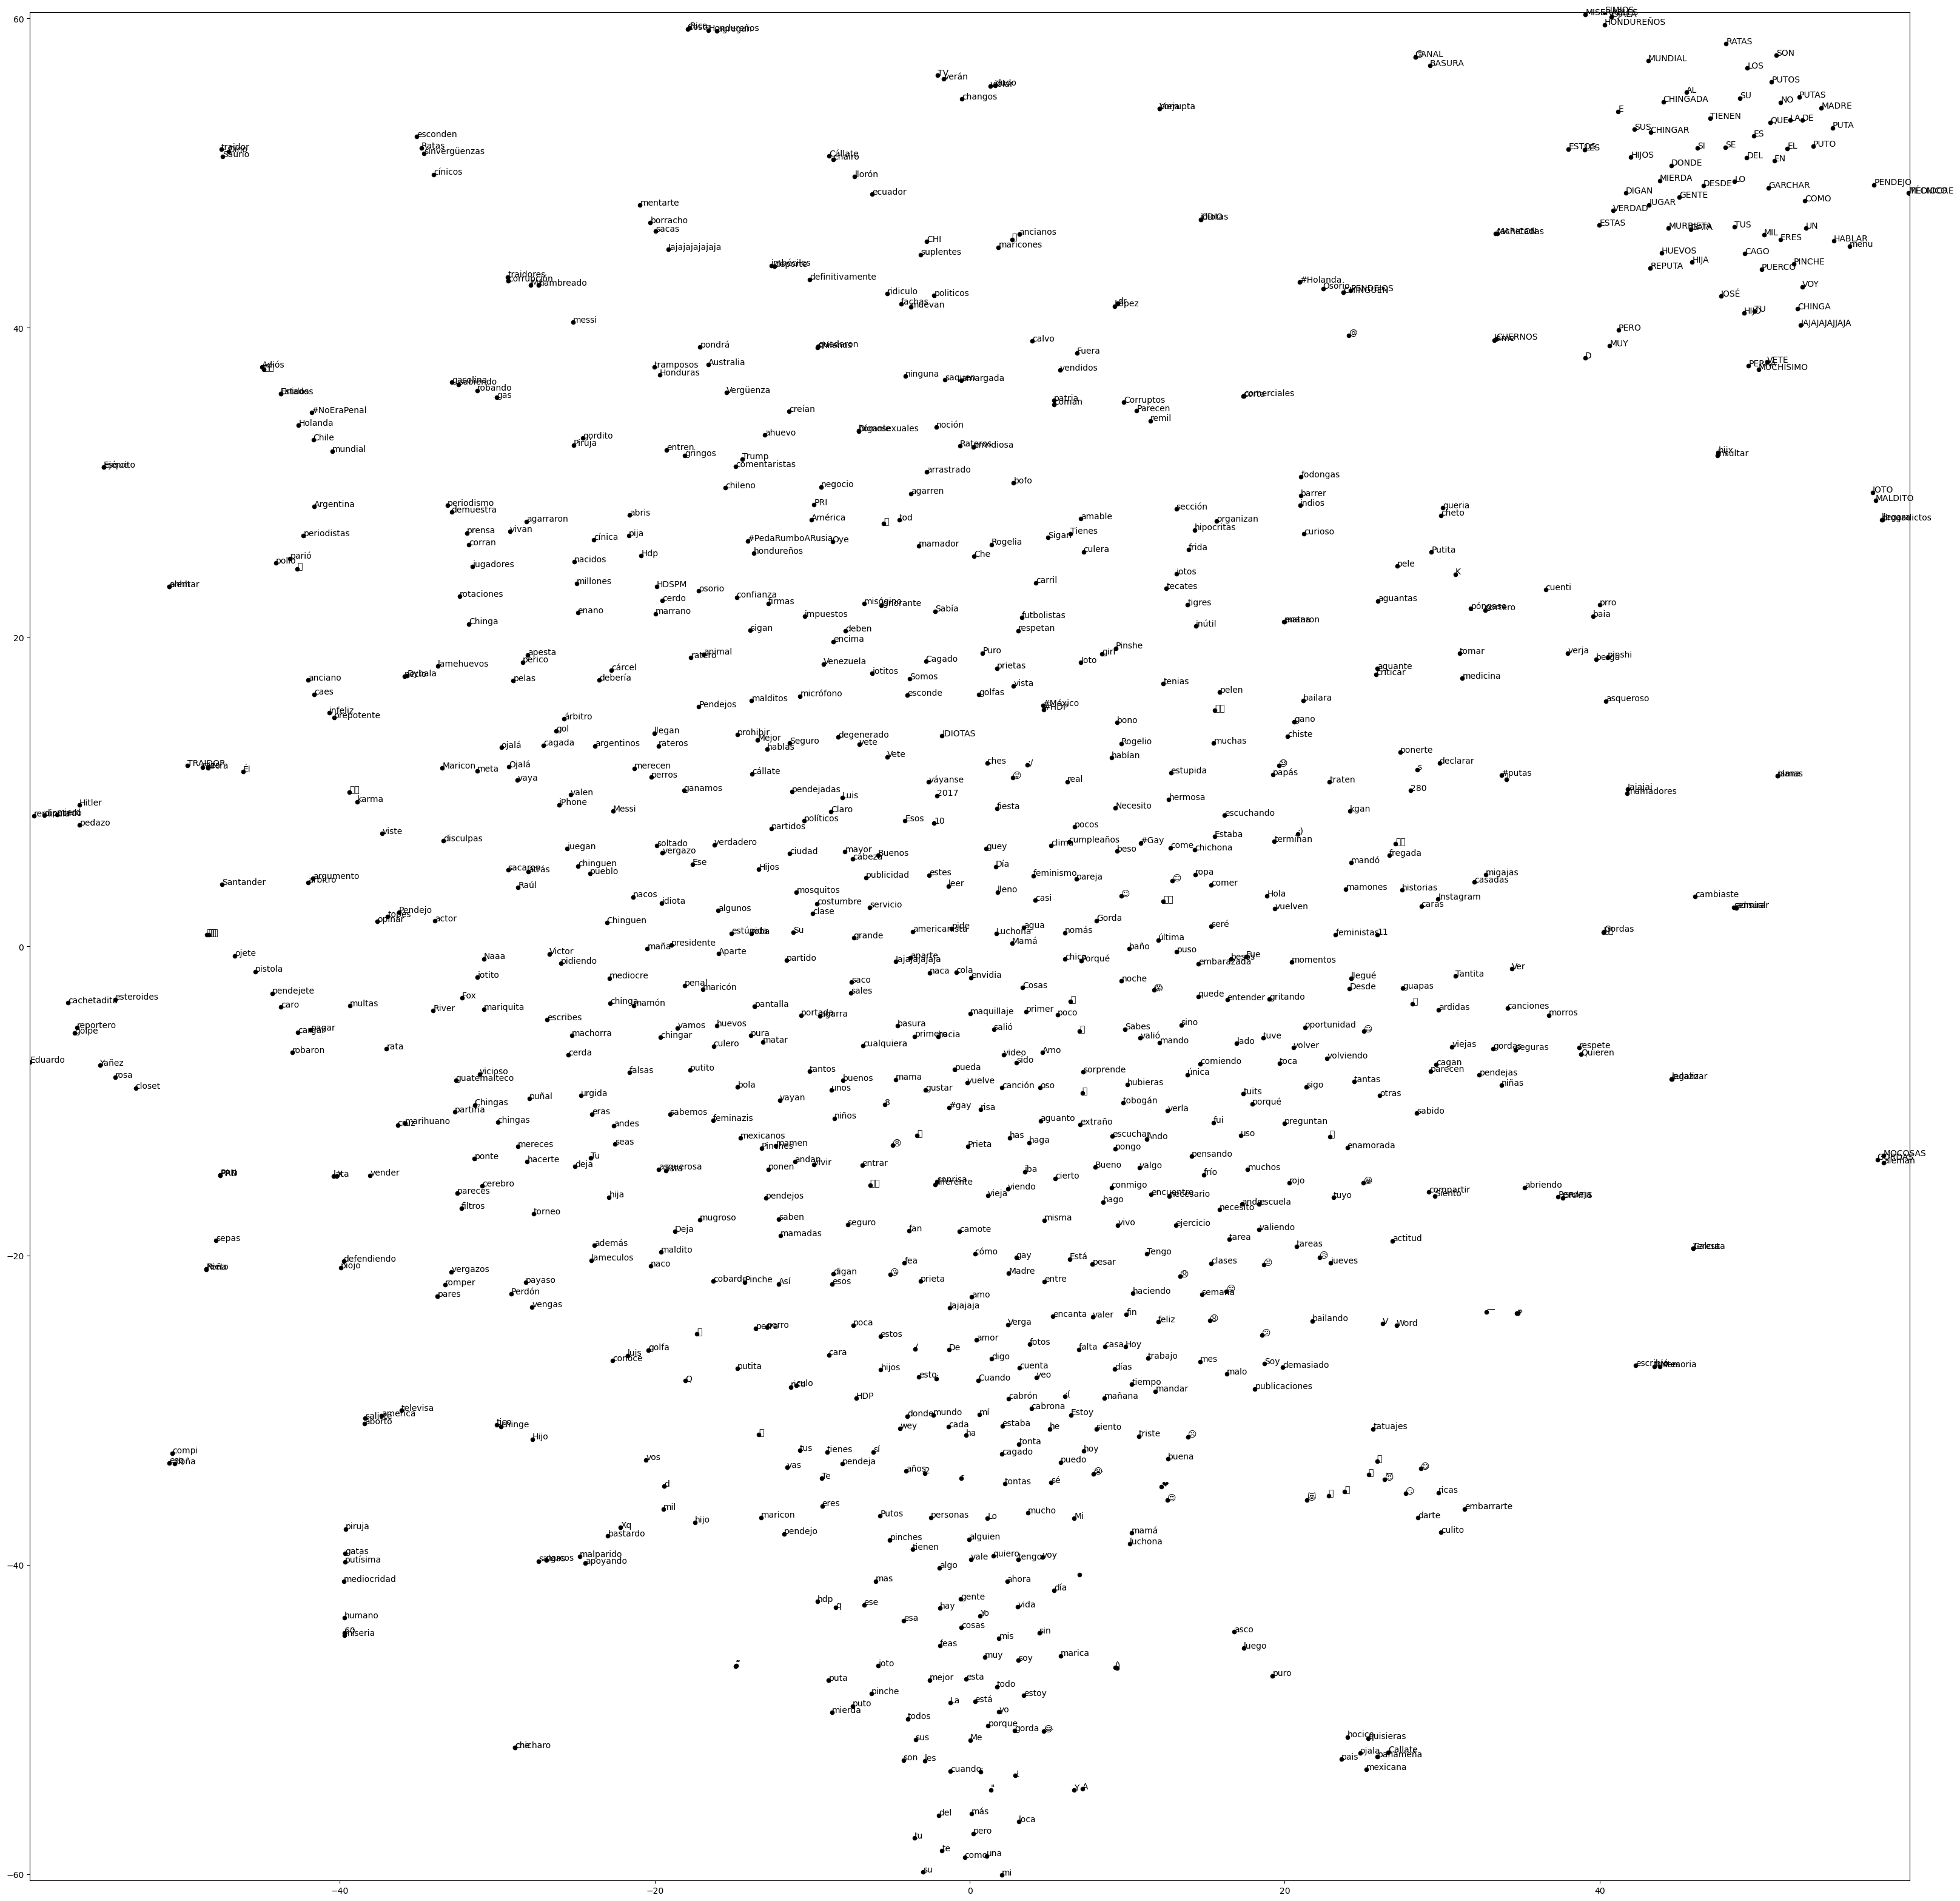

In [219]:
max_values = np.amax(reduced_matrix, axis=0)
max_x = max_values[0]
max_y = max_values[1]

plt.figure(figsize=(40, 40), dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color="black")

for idx, word in enumerate(target_words):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]

    plt.annotate(word, (x, y), color="black")

  * Gráfica con flechas

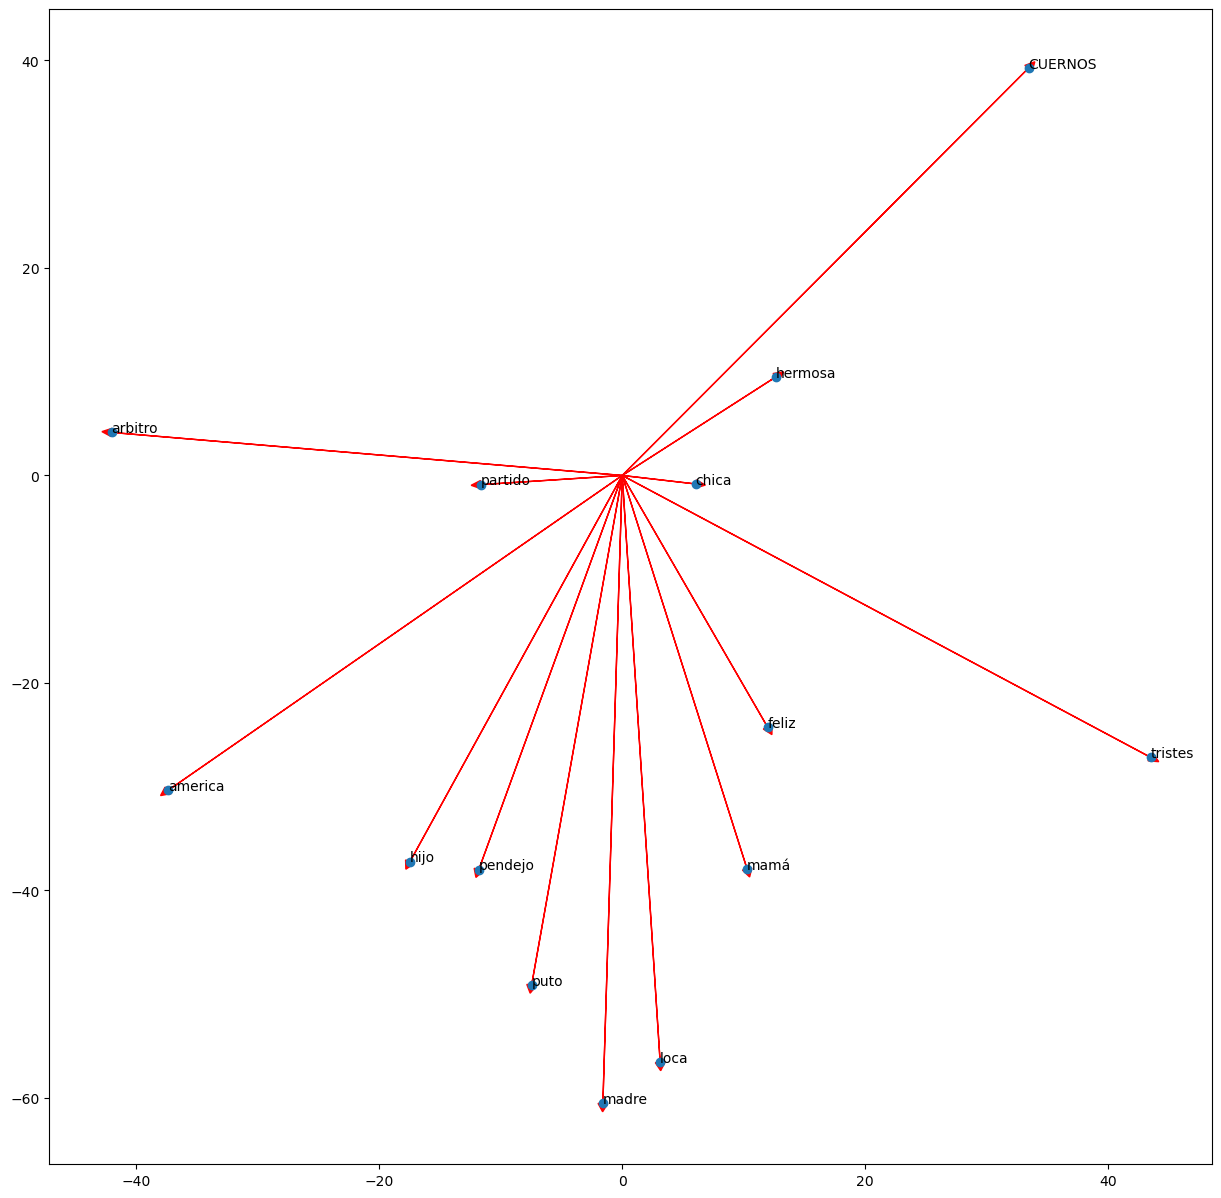

In [218]:
subset=["madre","hijo","loca","pendejo","mamá","tía","tristes","chica", "hermosa","CUERNOS","madre","feliz","hombre","mujer","ternura","feliz","puto","arbitro","america","partido","verguenza" ,"reniegan","Mañana", "hermosa","querer" ,"peda"]
ploted_subset=[]
subreduce_matrix=[]

for idx, word in enumerate(target_words[:]):
    if word in subset:
        ploted_subset +=[word]
        subreduce_matrix+= [reduced_matrix[idx]]

subreduce_matrix=np.array(subreduce_matrix)


fig,ax=plt.subplots(figsize=(15, 15))
col1=0
col2=1

for  word in subreduce_matrix:
    ax.arrow(0,0,word[col1],word[col2],head_width=0.8,head_length=0.8,fc='r',ec='r')

ax.scatter(subreduce_matrix[:,col1],subreduce_matrix[:,col2])

for i in range(len(ploted_subset)):
    ax.annotate(ploted_subset[i],(subreduce_matrix[i,col1],subreduce_matrix[i,col2]))

plt.show()

$$\textit{Random Indexing}$$

In [117]:
random_base=random_indexing(binary_bow_tr,2000)
#normalizamos
random_base=preprocessing.normalize(random_base,norm='l2')

In [118]:
random_base #no es sparse

array([[-0.00987033, -0.0383846 ,  0.02303076, ...,  0.01645054,
         0.02303076,  0.00438681],
       [-0.02479645, -0.0161716 ,  0.03234319, ...,  0.01185917,
         0.0172497 ,  0.01509349],
       [-0.00645931, -0.01507173,  0.00753587, ..., -0.00753587,
         0.02045449, -0.00968897],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.03589791],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.03548867,  0.        ],
       [ 0.03490024,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.03490024]])

  * Gráfica constelación

In [119]:
#escogemos los mil terminos relevantes de acuerdo a la clase de interes para graficar
feats=SelectKBest(chi2,k=1000)
feats.fit(frequency_bow_tr,tr_labels)
best_indices=feats.get_support(indices=True)

#generamos la matriz unicamente con los terminos relevantes
target_matrix = random_base[best_indices,:]  
words=[value for value in dict_indices]
#terminos relevantes
target_words=[words[index] for index in best_indices] 

In [120]:
#aplicamos pca
reduced_matrix=tsne(target_matrix,2)

Preprocessing the data using PCA...


Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.140717
Iteration 10: error is 18.109912
Iteration 20: error is 18.303749
Iteration 30: error is 18.455875
Iteration 40: error is 18.407302
Iteration 50: error is 18.194562
Iteration 60: error is 18.409424
Iteration 70: error is 18.618104
Iteration 80: error is 18.650739
Iteration 90: error is 18.700272
Iteration 100: error is 18.643939
Iteration 110: error is 2.733030
Iteration 120: error is 2.270332
Iteration 130: error is 2.011085
Iteration 140: error is 1.883357
Iteration 150: error is 1.803302
Iteration 160: error is 1.754267
Iteration 170: error is 1.715769
Iteration 180: error is 1.685871
Iteration 190: error is 1.661561
Iteration 200: error is 1.641068
Iteration 210: error is 1.623594
Iteration 220: error is 1.608831
Iteration 230: error is 1.596511
Iteration 240: error is 1.585927
Iteration 250: error is 1.576764
Iteration 260: error is 1.

/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  func(*args, **kwargs)
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  func(*args, **kwargs)
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from current font.
  func(*args, **kwargs)
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/pyt

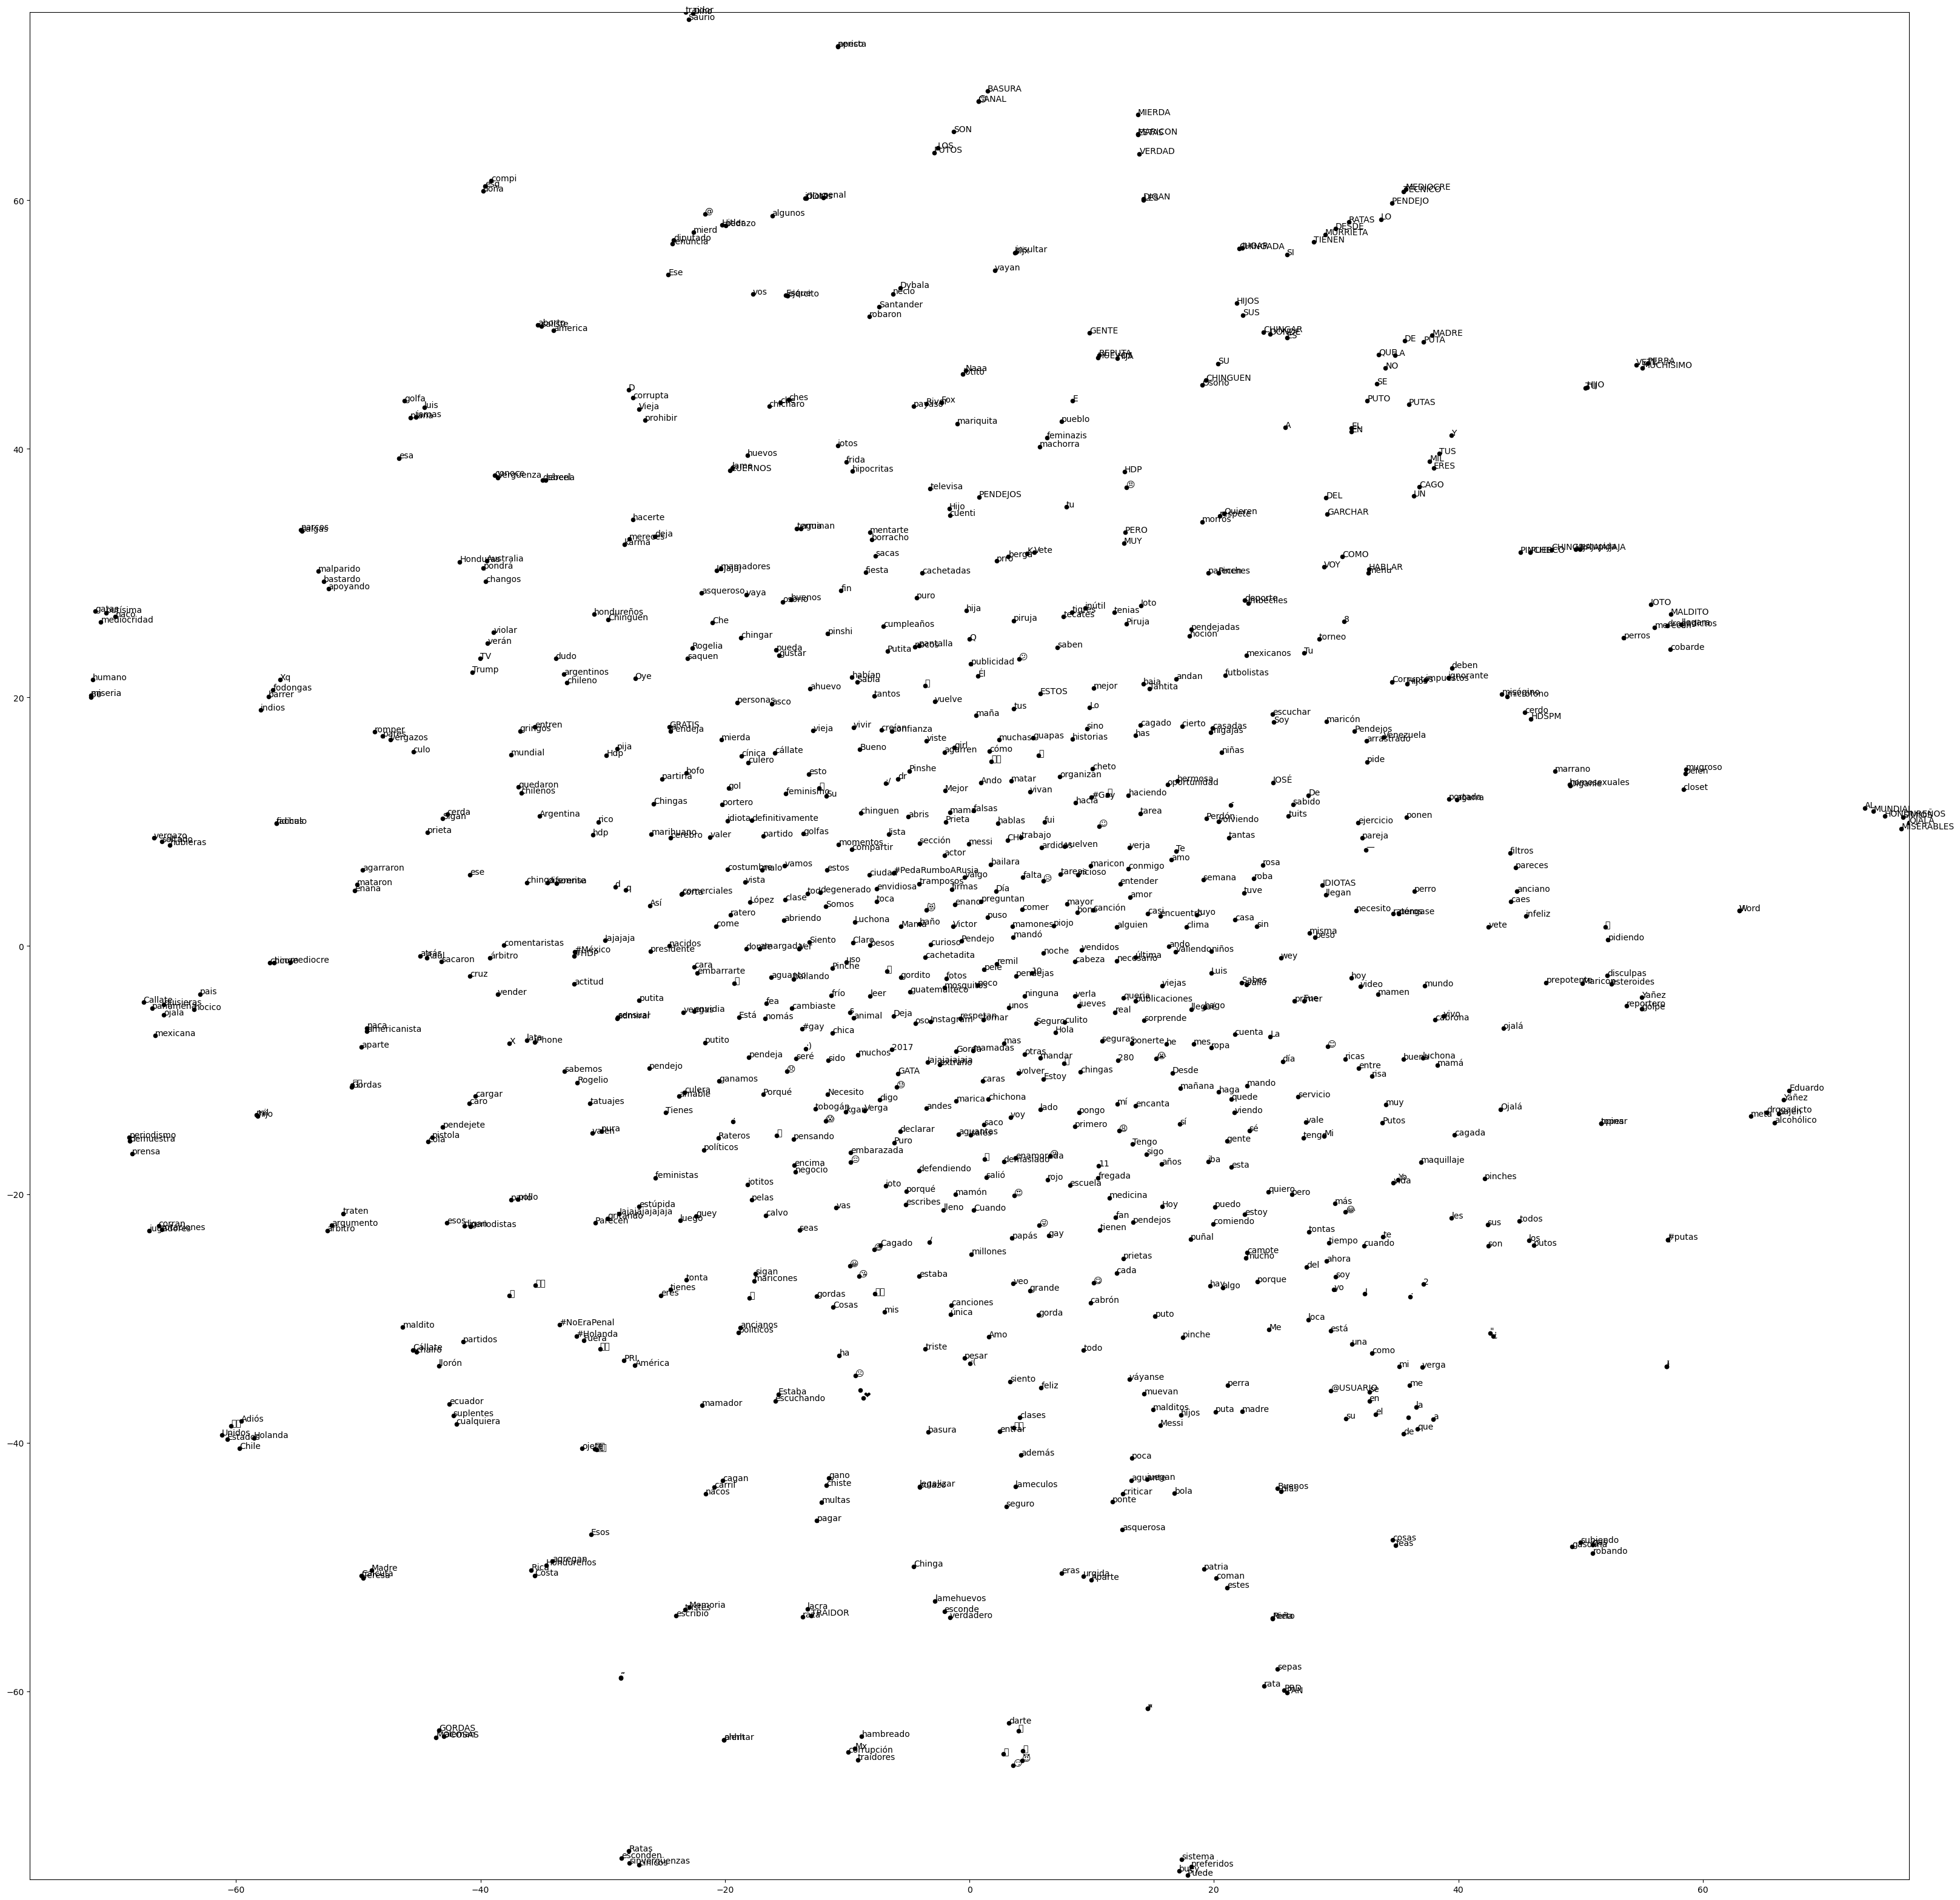

In [121]:
max_values = np.amax(reduced_matrix, axis=0)
max_x = max_values[0]
max_y = max_values[1]

plt.figure(figsize=(40, 40), dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color="black")

for idx, word in enumerate(target_words):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]

    plt.annotate(word, (x, y), color="black")

  * Gráfica de flechas

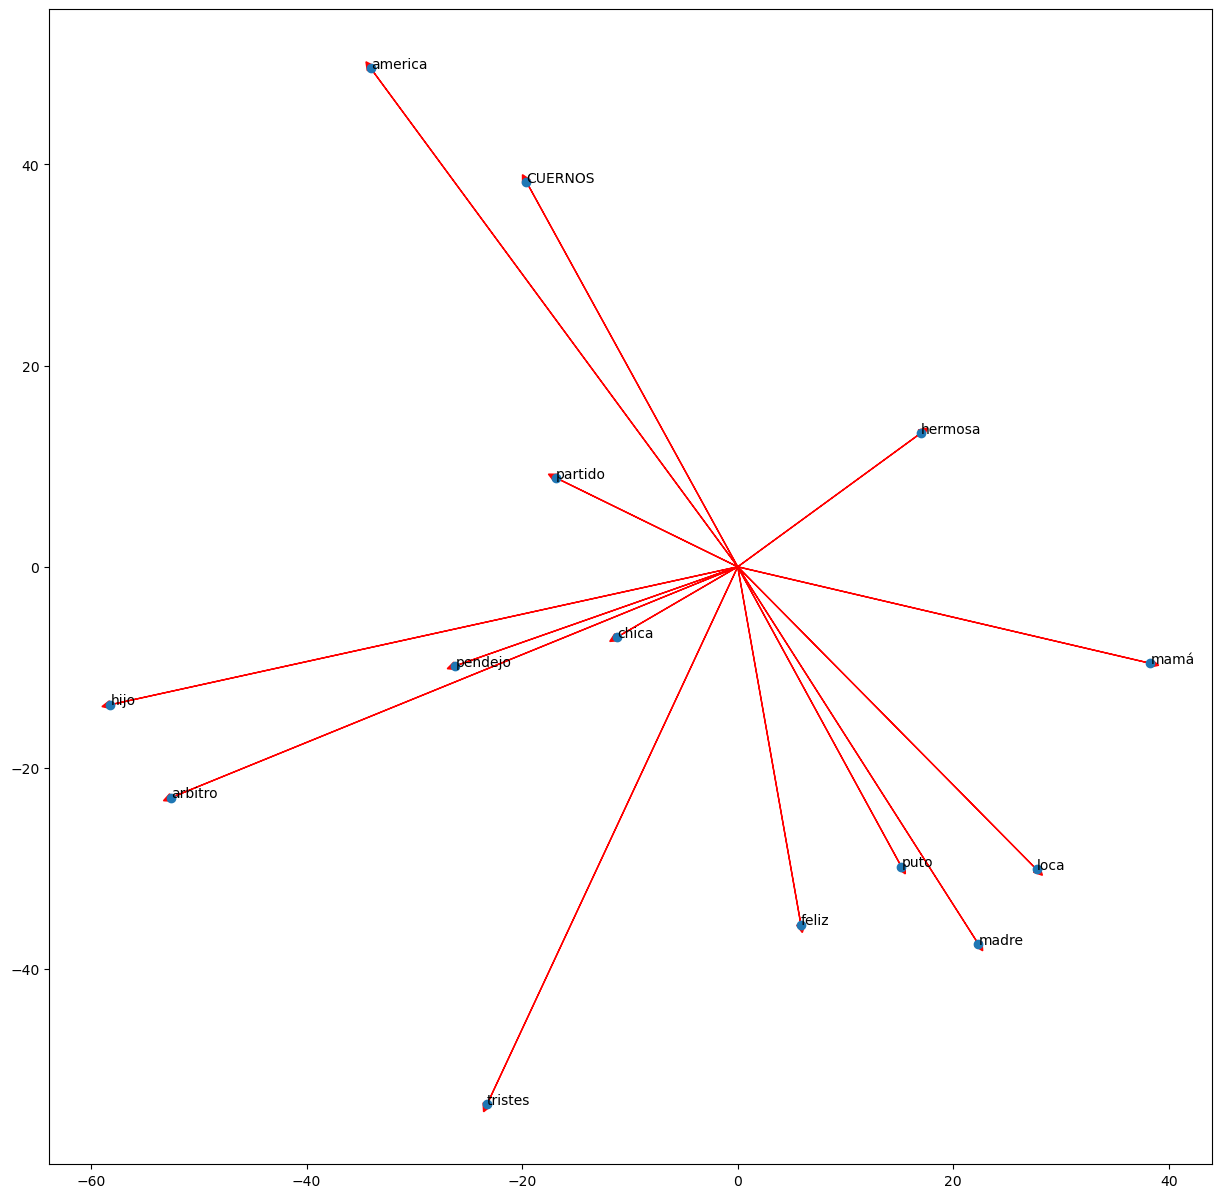

In [122]:
subset=["madre","hijo","loca","pendejo","mamá","tía","tristes","chica", "hermosa","CUERNOS","madre","feliz","hombre","mujer","ternura","feliz","puto","arbitro","america","partido"]
ploted_subset=[]
subreduce_matrix=[]

for idx, word in enumerate(target_words[:]):
    if word in subset:
        ploted_subset +=[word]
        subreduce_matrix+= [reduced_matrix[idx]]

subreduce_matrix=np.array(subreduce_matrix)


fig,ax=plt.subplots(figsize=(15, 15))
col1=0
col2=1

for  word in subreduce_matrix:
    ax.arrow(0,0,word[col1],word[col2],head_width=0.8,head_length=0.8,fc='r',ec='r')

ax.scatter(subreduce_matrix[:,col1],subreduce_matrix[:,col2])

for i in range(len(ploted_subset)):
    ax.annotate(ploted_subset[i],(subreduce_matrix[i,col1],subreduce_matrix[i,col2]))

plt.show()

$$\textit{Pequeña comparación de los vectores de contexto (DOR,TCOR y Random Indexing)}$$

In [123]:
print("El vector de contexto del token ""@USUARIO"" es:\n")
print("En el espacio de documetos (DOR)")
print(dor_base[9])
print("y tiene dimensión",len(dor_base[9]), "(número de documentos)\n")
print("En el espacio de terminos (TCOR), es")
print(tcor_base[9])
print("y tiene dimensión",len(tcor_base[9]), "(tamaño de vocabulario)\n")
print("Su representacion con Random Indexing, es")
print(random_base[9])
print("y tiene dimensión",len(random_base[9]), "(dimensión k elegida)\n")


El vector de contexto del token @USUARIO es:

En el espacio de documetos (DOR)
[0.03795192 0.02707756 0.         ... 0.         0.         0.        ]
y tiene dimensión 5278 (número de documentos)

En el espacio de terminos (TCOR), es
[0.05115184 0.05175525 0.05040884 ... 0.         0.         0.01863256]
y tiene dimensión 5000 (tamaño de vocabulario)

Su representacion con Random Indexing, es
[ 0.0016282   0.01139743  0.01139743 ... -0.00651282  0.01465384
 -0.0016282 ]
y tiene dimensión 2000 (dimensión k elegida)



Problema 3

* Clasificación de documentos 

In [160]:
def document_vectors(tcor_matrix, binary_bow):

    '''
    Esta funcion representa cada documento de la binary bow (filas) como un vector. 
    El vector que representa a un doc es el promedio de los vectores de cada termino en el documento


    '''
    n = np.shape(binary_bow)[0]  # Número de documentos
    m = np.shape(tcor_matrix)[0]  # Total de vocabulario

    # Creamos la matriz documento-termino
    document_word = np.zeros((n, m), dtype=float)

    # Recorremos los documentos en la bolsa de palabras binaria
    for doc_idx, doc in enumerate(binary_bow):
        # Las entradas distintas de cero, corresponden a las palabras que contiene el documento
        nonzero = np.nonzero(doc)[0]

        # Sumamos la contribución de cada término que aparece en el documento actual
        for i in nonzero:
            document_word[doc_idx] += tcor_matrix[i]

        if len(nonzero)!=0:
            document_word[doc_idx]=document_word[doc_idx]/len(nonzero)

    return document_word

In [161]:
doc_term=document_vectors(tcor_base,binary_bow_tr)
doc_term=preprocessing.normalize(doc_term,norm='l2') #normalizamos

In [162]:
np.shape(doc_term)

(5278, 5000)

In [163]:
doc_term

array([[0.1408775 , 0.16701485, 0.12996076, ..., 0.00157508, 0.0015068 ,
        0.00367573],
       [0.13867266, 0.11978954, 0.12774352, ..., 0.00118396, 0.00091002,
        0.00715712],
       [0.12669798, 0.12676126, 0.08543454, ..., 0.00523066, 0.00519512,
        0.00523066],
       ...,
       [0.10339279, 0.15067205, 0.10071127, ..., 0.00213348, 0.00213348,
        0.00213348],
       [0.11093209, 0.10761311, 0.10718014, ..., 0.00522908, 0.00300147,
        0.00581897],
       [0.13665183, 0.1303444 , 0.09351637, ..., 0.00393496, 0.00784622,
        0.00493458]])

In [164]:
#haemos los mismos pasos para validacion:
#1.contruir bolsa con pesado binario
binary_boW_validacion=build_binary_bow(val_txt,dict_freq,dict_indices)
#2. construir matriz de co-socurrencia (termino-termino)
coocurrence_validation=coocurrence_matrix(binary_boW_validacion)
#3.construir matriz tcor con a parit de la matrix de co-ocurrencia usando pesado visto en clase
tcor_base_validation=tcor(coocurrence_validation)
#3.1 normalizamos
tcor_base_validation=preprocessing.normalize(tcor_base_validation,norm='l2')
#4. construir la representación vectorial de los documentos a partir de la matriz tcor
doc_term_vaidation=document_vectors(tcor_base_validation,binary_boW_validacion)
#4.1 normalizamos
doc_term_vaidation=preprocessing.normalize(doc_term_vaidation,norm='l2')

In [165]:
#llamamos al clasificador y le pasamos la representacion vectorial de los documentos
grid.fit(doc_term,tr_labels)
#predicción
y_pred_tcor=grid.predict(doc_term_vaidation)

In [166]:
#llamamos al clasificador y le pasamos la bolsa de palabras TFIDF y las etiqutas
grid.fit(tfidf_bow_tr,tr_labels)
#predicción
y_pred_tfidf=grid.predict(tfidf_boW_validacion)

/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/.conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/lenguaje/

$$\textit{Comparación en clasificación TCOR y BoW TFIDF}$$

In [167]:
#medidas, reporte de clasificación,matriz de confusión
print("_____________Document Representation with TCOR_____________")
print(confusion_matrix(val_labels,y_pred_tcor))
print(metrics.classification_report(val_labels,y_pred_tcor))

_____________Document Representation with TCOR_____________
[[346  72]
 [ 67 102]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       418
           1       0.59      0.60      0.59       169

    accuracy                           0.76       587
   macro avg       0.71      0.72      0.71       587
weighted avg       0.77      0.76      0.76       587



In [169]:
#medidas, reporte de clasificación,matriz de confusión
print("_____________TfiDf BoW_____________")
print(confusion_matrix(val_labels,y_pred_tfidf))
print(metrics.classification_report(val_labels,y_pred_tfidf))

_____________TfiDf BoW_____________
[[356  62]
 [ 71  98]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       418
           1       0.61      0.58      0.60       169

    accuracy                           0.77       587
   macro avg       0.72      0.72      0.72       587
weighted avg       0.77      0.77      0.77       587



Problemas 4 y 5

* 10 pares de palabras más parecidas en toda la colección (TCOR)

In [273]:
def similitud_coseno(vec1, vec2):

    distancia = np.dot(vec1, vec2) 
    return distancia

def similitud_coseno_matrix(matrix):
    n = matrix.shape[0]  # Número de filas
    index_pairs = list(combinations(range(n), 2))  # Todas las combinaciones posibles de índices

    # Calcular la similitud del coseno para cada par de índices (por fila) y almacenar en una lista junto con el valor del coseno
    dist = [(i, j, similitud_coseno(matrix[i], matrix[j])) for i, j in index_pairs]

    # Ordenar la lista de acuerdo a la similitud del coseno
    dist.sort(key=lambda x: x[2], reverse=True)

    return dist

1. procesamos el tento de toda la coleccion

In [274]:
# Obtener la lista de palabras vacías
stop_words = set(stopwords.words('spanish'))  

In [275]:
coleccion=tr_txt+val_txt
#Generamos el corpus y tokenizamos
corpus_coleccion=create_corpus_from_text(coleccion,tokenizer)
#quitamos stopwords
corpus_coleccion_filtrado = [word for word in corpus_coleccion if word.lower() not in stop_words]
#Generamos diccionario de frecuencias con las primeras 5 mil palabras
dict_freq_coleccion=create_dic_freq(corpus_coleccion_filtrado,5000)
#Generamos diccionario de indices
dict_indices_coleccion=create_dic_ranking(dict_freq_coleccion)

In [276]:
inverted_dict_indices_colection = {value: key for key, value in dict_indices_coleccion.items()}

In [277]:
#generamos la bolsa de palabras con pesado binario de toda la coleccion
binary_bow_colection=build_binary_bow(coleccion,dict_freq_coleccion,dict_indices_coleccion)

In [278]:
#generamos la matrix tcor de toda la coleccion 
co_coleccion=coocurrence_matrix(binary_bow_colection)
tcor_base_coleccion=tcor(co_coleccion)
tcor_base_coleccion=preprocessing.normalize(tcor_base_coleccion,norm='l2')

2. generamos la lista con los 10 pares mas parecidos

In [279]:
#llamamos a la funcion que mide las distancia entre todas las filas de una matriz usando similitud coseno
lista_dist=similitud_coseno_matrix(tcor_base_coleccion)
#tomamos las 10 mas parecidas
top_10_similar_words_index = [pair[:2] for pair in lista_dist[:10]]

In [281]:
top_10_similar_words_index

[(2934, 2973),
 (3480, 4459),
 (3480, 4748),
 (4459, 4748),
 (4643, 4697),
 (1276, 1691),
 (2184, 2213),
 (2900, 2993),
 (2900, 2996),
 (2993, 2996)]

In [282]:
#buscamos 
for idx1, idx2 in top_10_similar_words_index:
    word1 = inverted_dict_indices_colection.get(idx1)
    word2 = inverted_dict_indices_colection.get(idx2)
    print(word1, word2)

Marquez Garcia
preferidos buey
preferidos Puede
buey Puede
Wars Star
litros 500
🚫 ✅
Ramos César
Ramos Costly
César Costly


*  10 pares de palabras más parecidas en toda la colección (BoW-TFIDF)

In [283]:
#generamos la bolsa de palabras con pesado binario de toda la coleccion
tfidf_bow_colection=build_tfidf_bow(coleccion,dict_freq_coleccion,dict_indices_coleccion)
tfidf_bow_colection=preprocessing.normalize(tfidf_bow_colection,norm='l2')

In [284]:
#llamamos a la funcion que mide las distancia entre todas las filas de una matriz usando similitud coseno
lista_dist_tfidf=similitud_coseno_matrix(tfidf_bow_colection)
#tomamos las 10 mas parecidas
top_10_similar_words_index_tfidf = [pair[:2] for pair in lista_dist_tfidf[:10]]

In [286]:
top_10_similar_words_index_tfidf

[(102, 1270),
 (102, 2328),
 (630, 2111),
 (630, 2222),
 (1245, 1985),
 (1270, 2328),
 (1836, 3329),
 (2111, 2222),
 (2574, 4875),
 (3354, 5583)]

In [287]:
#buscamos los documentos
for idx1, idx2 in top_10_similar_words_index_tfidf:
    word1 = coleccion[idx1]
    word2 = coleccion[idx2]
    print(word1, word2)
    print("--------------------")

@USUARIO Está cabron
 @USUARIO Está muy cabron hahahhaha

--------------------
@USUARIO Está cabron
 @USUARIO Esta increible cabron

--------------------
PUTA MADRE PINCE PROFE ESTUPIDO
 NOS IBAN A METER OTRO GOL PERO ERA UN DE PUTA MADRE AY ME MATE

--------------------
PUTA MADRE PINCE PROFE ESTUPIDO
 LA PUTA MADRE SE PINTÓ EL CABELLO DE AZULLLL

--------------------
Ya me tienen hasta la madre con el GPI
 No merezco a mi madre

--------------------
@USUARIO Está muy cabron hahahhaha
 @USUARIO Esta increible cabron

--------------------
Yo en Medicina Familiar y sus tontas mini-guardias
 ajajjj las chonis jajjjajaj que tontas son

--------------------
NOS IBAN A METER OTRO GOL PERO ERA UN DE PUTA MADRE AY ME MATE
 LA PUTA MADRE SE PINTÓ EL CABELLO DE AZULLLL

--------------------
Una flaquita TETONA recibe su dotación mientras chupa otra verga! ¡Mira su cara de placer!  RT para más vídeos
 Una flaquita TETONA recibe su dotación mientras chupa otra verga! ¡Mira su cara de placer! RT p

* 50 de las palabras más relevantes de TODA la
colección (Chi-2)